#Some Natural Language Processing: Using Trigram Hidden Markov Models to Tag Genes in Biological Text

This problem appeared as a programming assignment in the *coursera course Natural Language Processing* (**NLP**) by *Columbia University*. The following description of the problem is taken directly from the description of the assignment.

In this assignment, we need to build a **trigram hidden Markov model** to identify **gene names** in **biological
text**. Under this model, the *joint probability* of a sentence $$x_1, x_2, \ldots, x_n$$ and a tag sequence $$y_1, y_2, \ldots y_n$$. A basic *unigram* **HMM** is shown in the figure below. 

In [5]:
#ipython nbconvert pcaiso.ipynb
%matplotlib inline

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

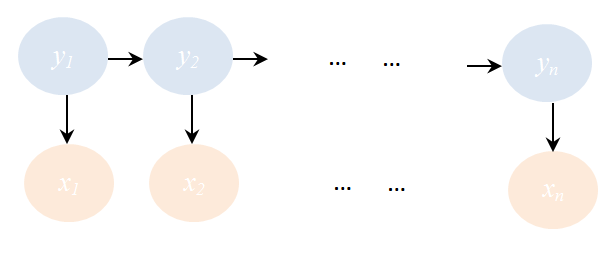

In [2]:
from IPython.display import Image
Image(filename='C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\im0.png')

Our goal in this assignment is to use **Trigram HMM** is defined as follows:

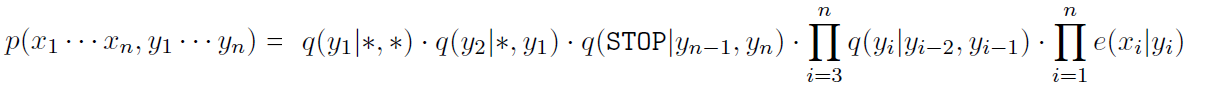

In [3]:
Image(filename='C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\f1.png')

where **\*** is a padding symbol that indicates the beginning of a sentence and **STOP** is a special **HMM state** indicating the end of a sentence. The task is to implement this *probabilistic model* and a **decoder** for finding the *most likely* **tag sequence** for *new sentences*.

A **labeled training** dataset gene.train, a **labeled** and **unlabeled** versions of the **development** set, gene.key and gene.dev, and an **unlabeled test** set gene.test are provided. The labeled files take the format of one word per line with **word** and **tag** separated by space and a single blank line separates sentences, e.g.,

Comparison O

with O

alkaline **I-GENE**

phosphatases **I-GENE**

and O

5 **I-GENE**

\- **I-GENE**

nucleotidase **I-GENE**

Pharmacologic O

aspects O

of O

neonatal O

hyperbilirubinemia O

. O

An **unlabeled test** dataset is also provided, the unlabeled file contains only the words of each sentence and will be used to evaluate the performance of the model deveploed.

There are **13796** sentences in the training dataset, whereas the dev dataset contains **509** sentences.

The task consists of **identifying gene names** within **biological text**. In this dataset there is one type of **entity**:
gene (**GENE**). The dataset is adapted from the BioCreAtIvE II shared task (http://biocreative.sourceforge.net/biocreative_2.html).

Here are the steps that are to be followed:

1. **Estimate** the **parameters** of the **Trigram HMM** from the training data.
2. Use the **parameters** learnt to compute the most likely tag sequence using **viterbi decoding** *dynamic programming* algorithm.

In [1]:
import sys
from collections import defaultdict
import math

"""
Count n-gram frequencies in a data file and write counts to
stdout. 
"""

def simple_conll_corpus_iterator(corpus_file):
    """
    Get an iterator object over the corpus file. The elements of the
    iterator contain (word, ne_tag) tuples. Blank lines, indicating
    sentence boundaries return (None, None).
    """
    l = corpus_file.readline()
    while l:
        line = l.strip()
        if line: # Nonempty line
            # Extract information from line.
            # Each line has the format
            # word pos_tag phrase_tag ne_tag
            fields = line.split(" ")
            ne_tag = fields[-1]
            #phrase_tag = fields[-2] #Unused
            #pos_tag = fields[-3] #Unused
            word = " ".join(fields[:-1])
            yield word, ne_tag
        else: # Empty line
            yield (None, None)                        
        l = corpus_file.readline()

def sentence_iterator(corpus_iterator):
    """
    Return an iterator object that yields one sentence at a time.
    Sentences are represented as lists of (word, ne_tag) tuples.
    """
    current_sentence = [] #Buffer for the current sentence
    for l in corpus_iterator:        
            if l==(None, None):
                if current_sentence:  #Reached the end of a sentence
                    yield current_sentence
                    current_sentence = [] #Reset buffer
                else: # Got empty input stream
                    sys.stderr.write("WARNING: Got empty input file/stream.\n")
                    raise StopIteration
            else:
                current_sentence.append(l) #Add token to the buffer

    if current_sentence: # If the last line was blank, we're done
        yield current_sentence  #Otherwise when there is no more token
                                # in the stream return the last sentence.

def get_ngrams(sent_iterator, n):
    """
    Get a generator that returns n-grams over the entire corpus,
    respecting sentence boundaries and inserting boundary tokens.
    Sent_iterator is a generator object whose elements are lists
    of tokens.
    """
    for sent in sent_iterator:
        #Add boundary symbols to the sentence
        w_boundary = (n-1) * [(None, "*")]
        w_boundary.extend(sent)
        w_boundary.append((None, "STOP"))
        #Then extract n-grams
        ngrams = (tuple(w_boundary[i:i+n]) for i in xrange(len(w_boundary)-n+1))
        for n_gram in ngrams: #Return one n-gram at a time
            yield n_gram   
            
class Hmm(object):
    """
    Stores counts for n-grams and emissions. 
    """

    def __init__(self, n=3):
        assert n>=2, "Expecting n>=2."
        self.n = n
        self.emission_counts = defaultdict(int)
        self.ngram_counts = [defaultdict(int) for i in xrange(self.n)]
        self.all_states = set()

    def train(self, corpus_file):
        """
        Count n-gram frequencies and emission probabilities from a corpus file.
        """
        ngram_iterator = \
            get_ngrams(sentence_iterator(simple_conll_corpus_iterator(corpus_file)), self.n)

        for ngram in ngram_iterator:
            #Sanity check: n-gram we get from the corpus stream needs to have the right length
            assert len(ngram) == self.n, "ngram in stream is %i, expected %i" % (len(ngram, self.n))

            tagsonly = tuple([ne_tag for word, ne_tag in ngram]) #retrieve only the tags            
            for i in xrange(2, self.n+1): #Count NE-tag 2-grams..n-grams
                self.ngram_counts[i-1][tagsonly[-i:]] += 1
            
            if ngram[-1][0] is not None: # If this is not the last word in a sentence
                self.ngram_counts[0][tagsonly[-1:]] += 1 # count 1-gram
                self.emission_counts[ngram[-1]] += 1 # and emission frequencies

            # Need to count a single n-1-gram of sentence start symbols per sentence
            if ngram[-2][0] is None: # this is the first n-gram in a sentence
                self.ngram_counts[self.n - 2][tuple((self.n - 1) * ["*"])] += 1

    def write_counts(self, output, printngrams=[1,2,3]):
        """
        Writes counts to the output file object.
        Format:

        """
        # First write counts for emissions
        for word, ne_tag in self.emission_counts:            
            output.write("%i WORDTAG %s %s\n" % (self.emission_counts[(word, ne_tag)], ne_tag, word))


        # Then write counts for all ngrams
        for n in printngrams:            
            for ngram in self.ngram_counts[n-1]:
                ngramstr = " ".join(ngram)
                output.write("%i %i-GRAM %s\n" %(self.ngram_counts[n-1][ngram], n, ngramstr))

    def read_counts(self, corpusfile):

        self.n = 3
        self.emission_counts = defaultdict(int)
        self.ngram_counts = [defaultdict(int) for i in xrange(self.n)]
        self.all_states = set()

        for line in corpusfile:
            parts = line.strip().split(" ")
            count = float(parts[0])
            if parts[1] == "WORDTAG":
                ne_tag = parts[2]
                word = parts[3]
                self.emission_counts[(word, ne_tag)] = count
                self.all_states.add(ne_tag)
            elif parts[1].endswith("GRAM"):
                n = int(parts[1].replace("-GRAM",""))
                ngram = tuple(parts[2:])
                self.ngram_counts[n-1][ngram] = count   

### Compute MLE parameters for HMM

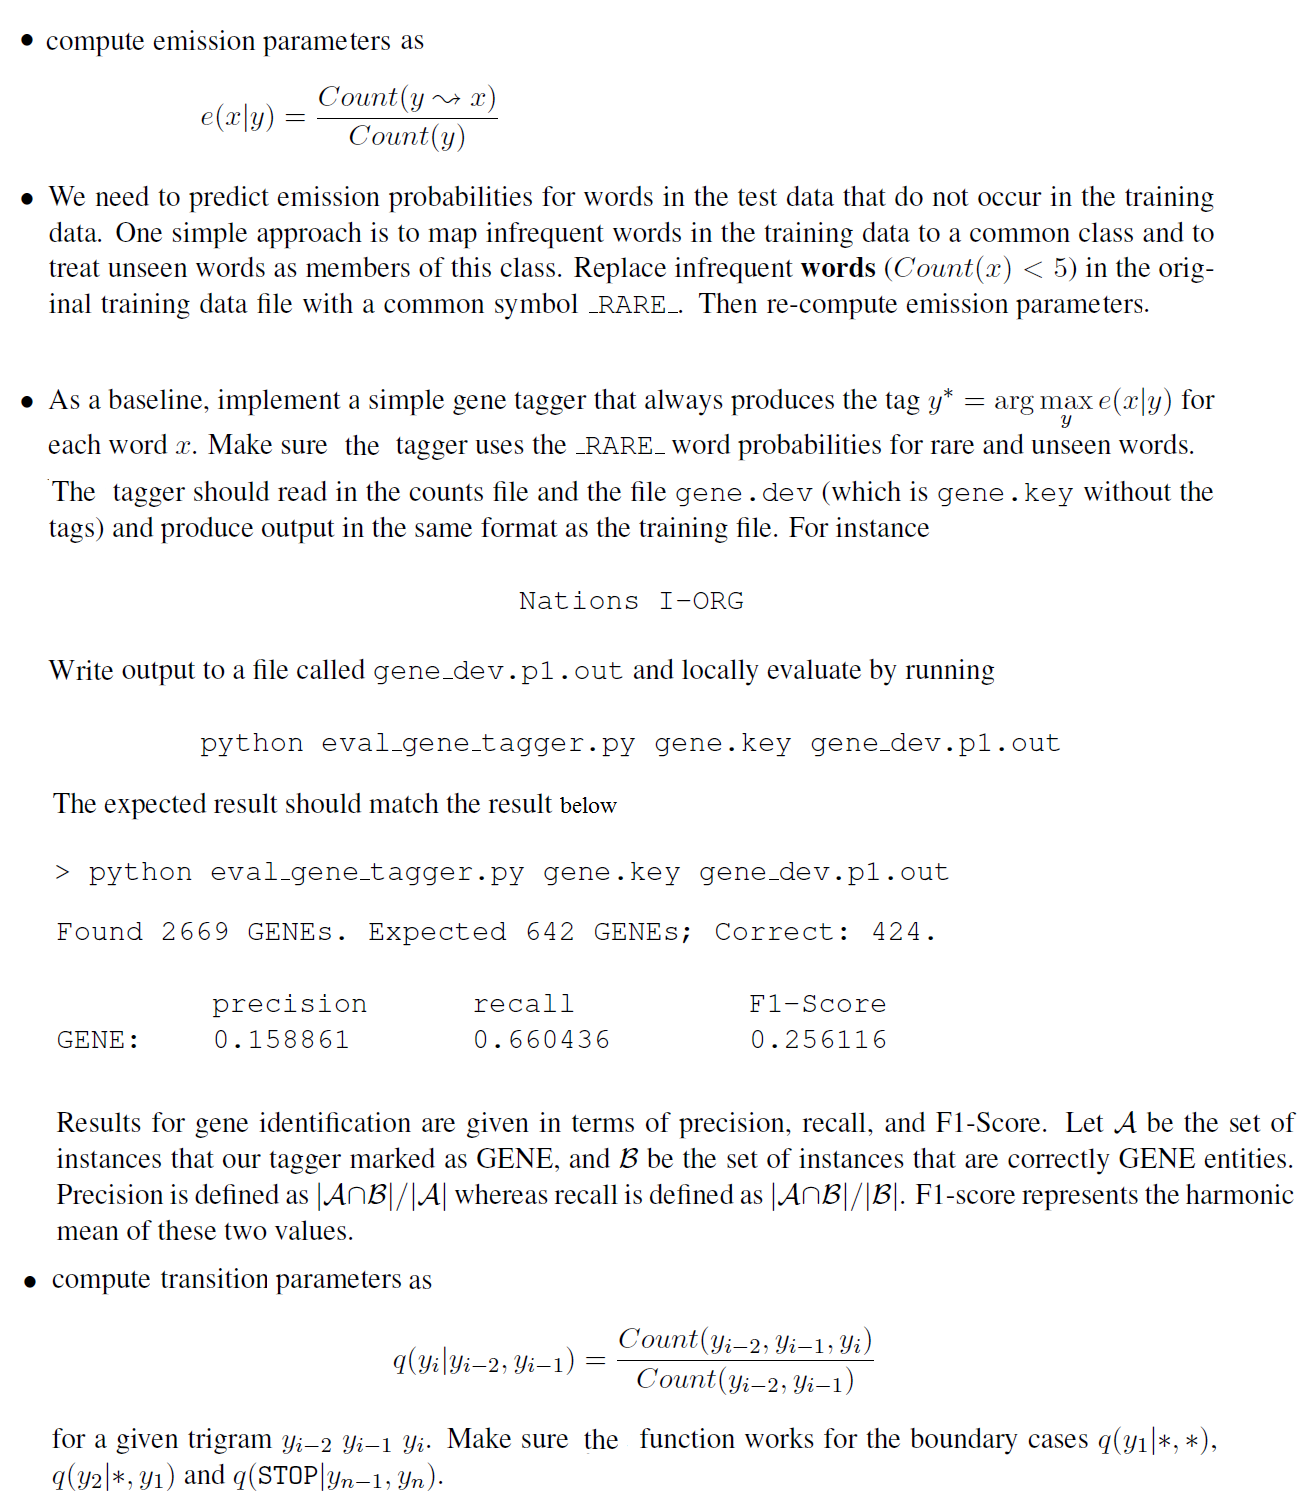

In [50]:
Image(filename='C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\im1.png')

In [2]:
import collections
def modify_input(input_train, modified_train):
    out = file(modified_train, "w")
    input_lines = file(input_train,"r").read().splitlines()
    words = [str.split(line, ' ')[0] for line in input_lines if line]
    counter = collections.Counter(words)
    rare_words = [w for w in counter if counter[w] < 5]
    #print rare_words
    out_str = ''
    for line in input_lines:
        if line:
            w, tag = str.split(line, ' ')
            out_str += ('_RARE_' if w in rare_words else w) + ' ' + tag + '\n'
        else:
            out_str += '\n'
    out.write(out_str)
    out.close()  
    return rare_words

def compute_MLE_params_and_predict_tags1(rare_words, input_count, input_test, output):
    e, q = {}, {}
    for line in file(input_count,"r").read().splitlines():
        words = str.split(line, ' ')
        if words[1] == 'WORDTAG':
            e[words[3], words[2]] = int(words[0])
        elif words[1] == '1-GRAM':
            q[words[2]] = int(words[0])
        elif words[1] == '2-GRAM':
            q[words[2], words[3]] = int(words[0])
        elif words[1] == '3-GRAM':
            q[words[2], words[3], words[4]] = int(words[0])
    for (x,y) in e:
        e[x,y] = e[x,y] / float(q[y])
    # print e
    for (y1, y2, y3) in q:
        q[y1, y2, y3] = q[y1, y2, y3] / float(q[y1, y2])
    # print q
    
    tags = {}
    for (x,y) in e:
        _, prob = tags.get(x, (None, 0))
        if prob <= e[x,y]:
            tags[x] = (y, e[x,y])            
    test, out = file(input_test,"r"), file(output, "w")
    for x in test.read().splitlines():
        if x:
            key = '_RARE_' if (x in rare_words) or (not x in tags) else x
            out.write(x + ' ' + str(tags[key][0]) + '\n')
        else:
            out.write('\n')
    out.close()    
    
    return (e, q, rare_words, tags)

#path = 'C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\'    
#rare_words = modify_input(path + 'gene.train', path + 'gene.mod.train')
#e, q, rare_words, tags = compute_MLE_params_and_predict_tags1(rare_words, path+'gene.counts', path+'gene.dev', path+'gene_dev.p1.out')

In [3]:
def compute_MLE_params_and_predict_tags(input_train, input_test, output):
    # Initialize a trigram counter
    counter = Hmm(3)
    # Collect counts
    counter.train(file(input_train,"r"))  
    Counts = {}
    for (x,y) in counter.emission_counts:
        Counts[x] = Counts.get(x,0) + counter.emission_counts[(x,y)]
    #print Counts    
    rare_words = [x for x in Counts if Counts[x] < 5]
    for (x,y) in counter.emission_counts.keys():
        if x in rare_words:
            counter.emission_counts['_RARE_',y] = counter.emission_counts.get(('_RARE_',y), 0) + counter.emission_counts[x,y]
            del counter.emission_counts[x,y]
    e = {(x,y):counter.emission_counts[(x,y)] / float(counter.ngram_counts[0][(y,)]) for (x,y) in counter.emission_counts}
    # print e
    q = {(y1,y2,y3):counter.ngram_counts[2][y1,y2,y3]/float(counter.ngram_counts[1][y1,y2]) for (y1,y2,y3) in counter.ngram_counts[2]}
    # print q
    
    tags = {}
    for (x,y) in e:
        _, prob = tags.get(x, (None, 0))
        if prob <= e[x,y]:
            tags[x] = (y, e[x,y])            
    test, out = file(input_test,"r"), file(output, "w")
    for x in test.read().splitlines():
        if x:
            key = '_RARE_' if (x in rare_words) or (not x in tags) else x
            out.write(x + ' ' + str(tags[key][0]) + '\n')
        else:
            out.write('\n')
    out.close()    
    
    return (e, q, rare_words, tags)
    
path = 'C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\'    
e, q, rare_words, tags = compute_MLE_params_and_predict_tags(path+'gene.train', path+'gene.dev', path+'gene_dev.p1.out')
# python eval_gene_tagger.py gene.key gene_dev.p1.out

### Parameters estimated for HMM

The computed **q** parameter for **HMM Tagger** with **MLE** using the training dataset is shown below.

In [47]:
q

{('*', '*', 'I-GENE'): 0.05429109886923746,
 ('*', '*', 'O'): 0.9457089011307626,
 ('*', 'I-GENE', 'I-GENE'): 0.6034712950600801,
 ('*', 'I-GENE', 'O'): 0.3951935914552737,
 ('*', 'I-GENE', 'STOP'): 0.0013351134846461949,
 ('*', 'O', 'I-GENE'): 0.04545106154671572,
 ('*', 'O', 'O'): 0.9543190005365219,
 ('*', 'O', 'STOP'): 0.00022993791676247414,
 ('I-GENE', 'I-GENE', 'I-GENE'): 0.6057704112952732,
 ('I-GENE', 'I-GENE', 'O'): 0.3937794147738899,
 ('I-GENE', 'I-GENE', 'STOP'): 0.0004501739308369143,
 ('I-GENE', 'O', 'I-GENE'): 0.20999759384023098,
 ('I-GENE', 'O', 'O'): 0.6809432146294514,
 ('I-GENE', 'O', 'STOP'): 0.10905919153031761,
 ('O', 'I-GENE', 'I-GENE'): 0.5778575025176234,
 ('O', 'I-GENE', 'O'): 0.422079556898288,
 ('O', 'I-GENE', 'STOP'): 6.294058408862034e-05,
 ('O', 'O', 'I-GENE'): 0.03741872901853501,
 ('O', 'O', 'O'): 0.9246458312860389,
 ('O', 'O', 'STOP'): 0.037935439695426}

The following result shows the tag sequences generated with **trigram HMM** using the **baseline tagger model**, comparing it with the  **gold standard** tag seuqences on the dev dataset for a sentence. The accuracy in terms of **F-Score** is pretty low, it's around **25.6%**, as expected. 

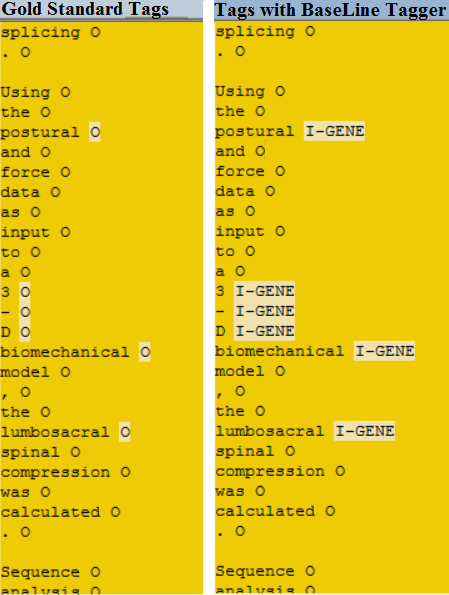

In [7]:
Image(filename='C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\im3.png')

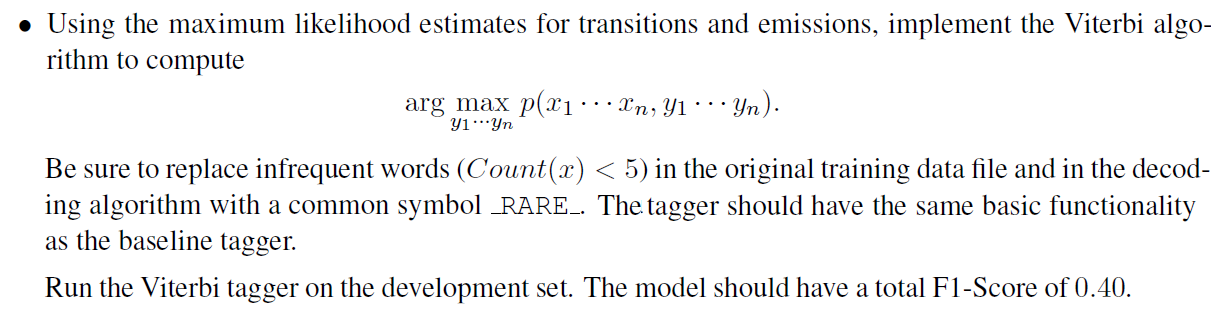

In [53]:
Image(filename='C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\im2.png')

The **Viterbi Decoding Algorithm** to be implemented is shown in the next figure:

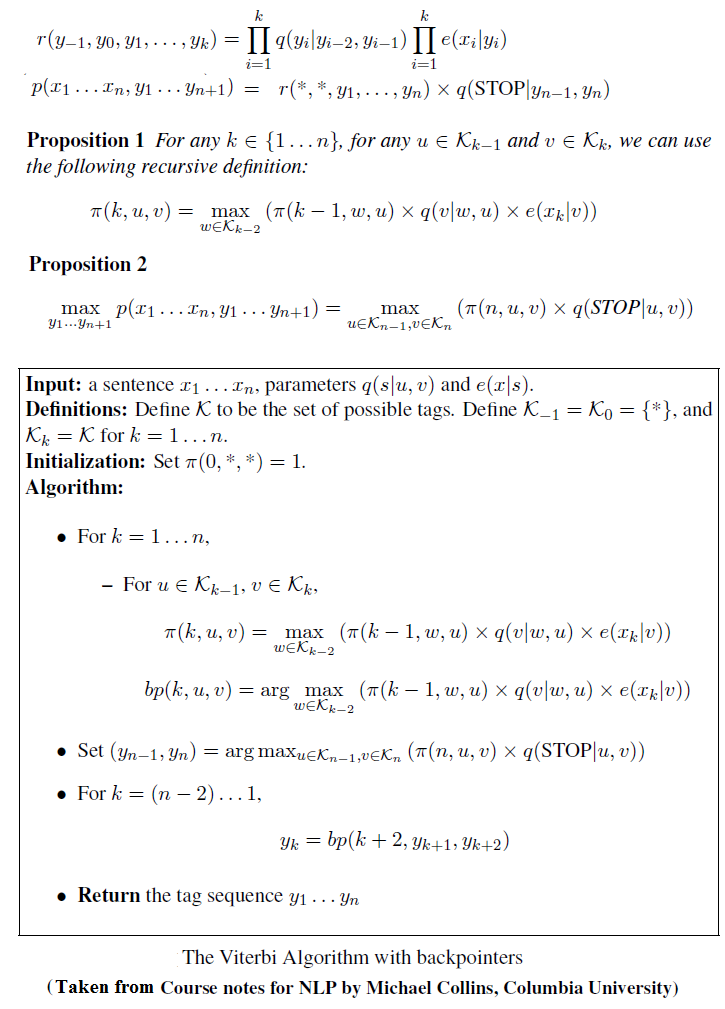

In [45]:
Image(filename='C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\viterbi.png')

In [6]:
from math import log, exp

def log1(x):
    return log(x) if x > 0 else -float('inf')

def K(tags, k):
    return tags if k > 0 else ['*']

def viterbi_decoding(x, q, e):
    D, bp = {}, {}
    n = len(x)
    y = [0]*n
    tags = set(sum([list(k) for k in q.keys()],[])) - set(['*', 'STOP']) 
    D[0, '*', '*'] = 1
    for k in range(1,n+1):
        for u in K(tags,k-1):
            for v in K(tags,k):
                #print x[k-1], v
                #D[k,u,v], bp[k,u,v] = max([(D[k-1,w,u]*q[w,u,v]*e[x[k-1],v], w) for w in K(tags, k-2)])
                #D[k,u,v], bp[k,u,v] = max([(D[k-1,w,u]*q[w,u,v]*e.get((x[k-1],v),0), w) for w in K(tags, k-2)])
                D[k,u,v], bp[k,u,v] = max([(exp(log1(D[k-1,w,u])+log1(q[w,u,v])+log1(e.get((x[k-1],v),0))), w) for w in K(tags, k-2)])
    #_, y[n-2], y[n-1] = max([(D[n,u,v]*q[u,v,'STOP'],u,v) for u in K(tags, n-1) for v in K(tags,n)])
    _, y[n-2], y[n-1] = max([(exp(log1(D[n,u,v])+log1(q[u,v,'STOP'])),u,v) for u in K(tags, n-1) for v in K(tags,n)])
    #print D
    for k in range(n-2, 0, -1):
        y[k-1] = bp[k+2, y[k], y[k+1]]
    return y

In [7]:
n = 3
path = 'C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\'    
test, out = file(path+'gene.dev',"r"), file(path+'gene_dev.p2.out', "w")
for sentence in sentence_iterator(simple_conll_corpus_iterator(test)):
	x = [w[1] for w in sentence]
	#print x
	x_new = ['_RARE_' if (x[i] in rare_words) or (not x[i] in tags) else x[i] for i in range(len(x))] 
	y = viterbi_decoding(x_new, q, e)
	#print len(x), len(y), y
	for i in range(len(x)):
		out.write(x[i] + ' ' + y[i] + '\n')
	out.write('\n')
out.close() 
# python eval_gene_tagger.py gene.key gene_dev.p2.out

The following result shows the tag sequences generated with **trigram HMM** using the **viterbi tagger model**, comparing it with the  **gold standard** tag seuqences on the dev dataset for a sentence. The accuracy in terms of **F-Score** improves quite a bit, it's around **39.9%** now, as expected. 

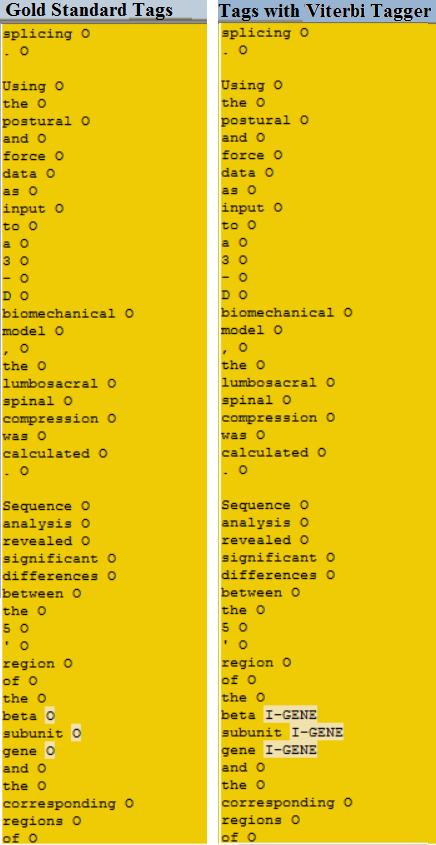

In [8]:
Image(filename='C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\im4.png')

* Now, **HMM taggers** can be improved by **grouping words** into **informative word classes** rather than just into a single class of **rare words**. For this part we need to implement four rare word classes:

    1. **Numeric** The word is rare and contains at least one numeric characters.
    2. **All Capitals** The word is rare and consists entirely of capitalized letters.
    3. **Last Capital** The word is rare, not all capitals, and ends with a capital letter.
    4. **Rare** The word is rare and does not fit in the other classes.

These can be implemented by replacing words in the original training data and re-learning the HMM parameters with **MLE**. Be sure to also replace words while testing. The expected total **development F1-Score** is **0:42**.

In [ ]:
def compute_MLE_params_with_rare_groups(input_train, input_test):
    # Initialize a trigram counter
    counter = Hmm(3)
    # Collect counts
    counter.train(file(input_train,"r"))  
    Counts = {}
    for (x,y) in counter.emission_counts:
        Counts[x] = Counts.get(x,0) + counter.emission_counts[(x,y)]
    #print Counts    
    rare_words = [x for x in Counts if Counts[x] < 5]
    for (x,y) in counter.emission_counts.keys():
        if x in rare_words:
            type = '_NUM_' if any([ch.isdigit() for ch in x]) else '_RARE_'
            if type == '_RARE_': type = '_ACAP_' if all([ch.isupper() for ch in x]) else '_RARE_'
            if type == '_RARE_': type = '_LCAP_' if x[-1].isupper() else '_RARE_'
            counter.emission_counts[type,y] = counter.emission_counts.get((type,y), 0) + counter.emission_counts[x,y]
            del counter.emission_counts[x,y]
    e = {(x,y):counter.emission_counts[(x,y)] / float(counter.ngram_counts[0][(y,)]) for (x,y) in counter.emission_counts}
    # print e
    q = {(y1,y2,y3):counter.ngram_counts[2][y1,y2,y3]/float(counter.ngram_counts[1][y1,y2]) for (y1,y2,y3) in counter.ngram_counts[2]}
    # print q
        
    return (e, q, rare_words, tags)
    
path = 'C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\'    
e, q, rare_words, tags = compute_MLE_params_with_rare_groups(path+'gene.train', path+'gene.dev')

In [23]:
n = 3
path = 'C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\'    
test, out = file(path+'gene.dev',"r"), file(path+'gene_dev.p3.out', "w")
for sentence in sentence_iterator(simple_conll_corpus_iterator(test)):
    x = [w[1] for w in sentence]
    #print x
    x_new = [w for w in x]
    for i in range(len(x_new)):
        if (x_new[i] in rare_words) or (not x_new[i] in tags):
            type = '_NUM_' if any([ch.isdigit() for ch in x_new[i]]) else '_RARE_'
            if type == '_RARE_': type = '_ACAP_' if all([ch.isupper() for ch in x_new[i]]) else '_RARE_'
            if type == '_RARE_': type = '_LCAP_' if x_new[i][-1].isupper() else '_RARE_'
            x_new[i] = type            
    y = viterbi_decoding(x_new, q, e)
    #print len(x), len(y), y
    for i in range(len(x)):
        out.write(x[i] + ' ' + y[i] + '\n')
    out.write('\n')
out.close() 
# python eval_gene_tagger.py gene.key gene_dev.p3.out

The following result shows the tag sequences generated with **trigram HMM** using the **viterbi tagger model with rare word groupings**, comparing it with the  **gold standard** tag seuqences and **viterbi tagger model without rare word groupings** on the dev dataset for a couple of sentences. The accuracy in terms of **F-Score** improves more, it's around **42%** now, as expected. 

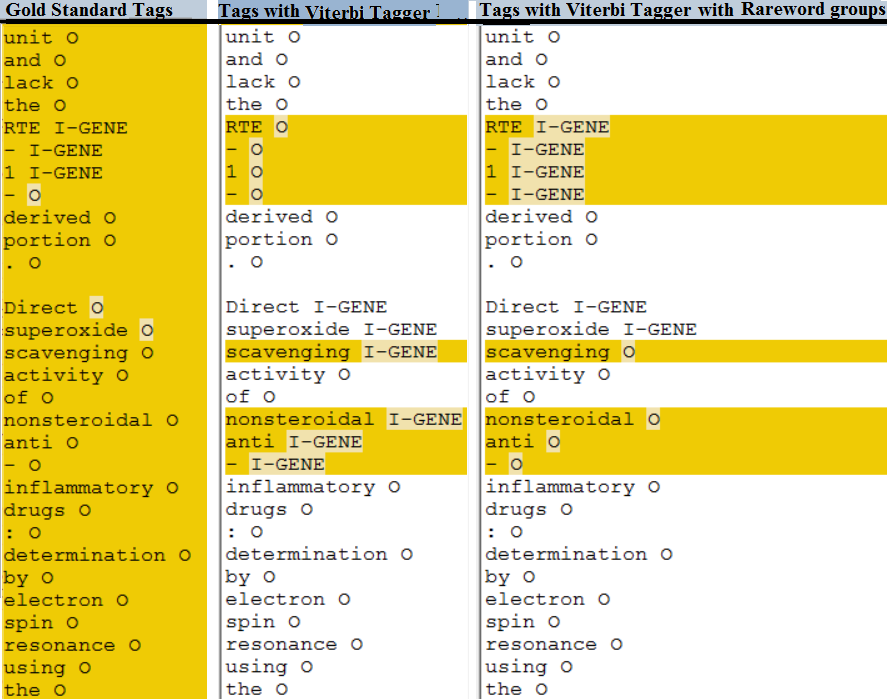

In [9]:
Image(filename='C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\im5.png')

##Summary of Results

In [10]:
import pandas as pd
df = pd.DataFrame({'Tagger':'Baseline', 'Precision':0.158861,'Recall':0.660436, 'F1-Score':0.256116}, index=[0])
df = df.append(pd.DataFrame({'Tagger':'Viterbi', 'Precision':0.541555,'Recall':0.314642, 'F1-Score':0.398030}, index=[1]))
df = df.append(pd.DataFrame({'Tagger':'Viterbi with Rareword groups', 'Precision':0.534940,'Recall':0.345794, 'F1-Score':0.420057}, index=[2]))
df = df[['Tagger', 'Precision', 'Recall', 'F1-Score']]
df.head()

,Tagger,Precision,Recall,F1-Score
0,Baseline,0.158861,0.660436,0.256116
1,Viterbi,0.541555,0.314642,0.398030
2,Viterbi with Rareword groups,0.534940,0.345794,0.420057


In [11]:
#df = pd.melt(df, id_vars=['Tagger'], value_vars=['Precision', 'Recall', 'F1-Score'])
#df.head(10)
#import seaborn as sns
#sns.barplot(x="variable", y="value", hue="Tagger", data=df)

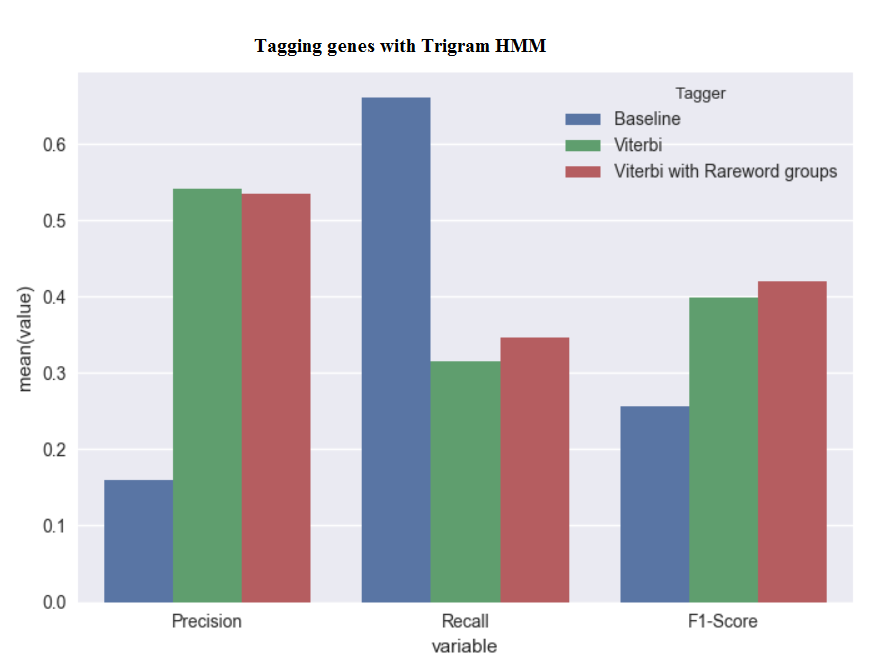

In [46]:
Image(filename='C:\\courses\\Coursera\\Past\\NLP\\Columbia - NLP\\Assignment\\h1\\im6.png')